#  <center>**Maestría en Ciencia de Datos y Analítica**</center>
## <center>**Algebra de Datos: Trabajo 1**</center>
### <center>**Autor**:</center>
#### <center>**Sebastian Carvalho Salazar**</center>
#### <center>**Johan Stiven Paez Bermudez**</center>
#### <center>**Sebastian Ramirez Escobar**</center>

# Importar Librerias

---

In [43]:
# Ignorar todos los warnings
import warnings
warnings.filterwarnings('ignore')

In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from skimage import exposure
import seaborn as sns
import numpy as np
import pickle
import math
import cv2
import os

  # Sistema de Archivos (Dataset)

  ---

In [45]:
os.listdir('dataset')

['Female Faces 200', 'Male Faces 200', 'Pruebas']

# Cargar Datos
---

In [46]:
def cargar_datos(ruta_carpeta, label):
    X = []
    y = []
    for archivo in os.listdir(ruta_carpeta):
        if archivo.endswith(".jpg") or archivo.endswith(".jpeg") or archivo.endswith(".png"):
            imagen = cv2.imread(os.path.join(ruta_carpeta, archivo), cv2.IMREAD_GRAYSCALE)
            imagen = cv2.resize(imagen, (400, 600))
            imagen = exposure.equalize_hist(imagen)
            X.append(imagen.flatten())
            y.append(label)
    return np.array(X), np.array(y)

In [47]:
# Se definen las rutas
male_path = 'dataset/Male Faces 200'
female_path = 'dataset/Female Faces 200'

male_data, male_labels = cargar_datos(male_path, 1)
female_data, female_labels = cargar_datos(female_path, 0)

In [48]:
# Unir los datos y etiquetas de hombres y mujeres
X = np.concatenate((male_data, female_data), axis=0)
y = np.concatenate((male_labels, female_labels), axis=0)

# Dividir en datos de Train y Test
---

In [49]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

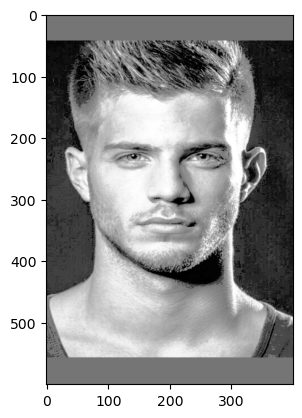

In [50]:
# Mostrar una imagen aleatoria del conjunto de datos
plt.imshow(X_train[np.random.randint(0, len(X_train))].reshape(600,400,1), cmap='gray')

In [51]:
# Dimensiones
X_train.shape

(320, 240000)

# Aumento de Datos
---

In [52]:
def aumentar_datos(X_train, y_train, max_augmented_images=1):
    # Crear un generador de aumento de datos para los datos de entrenamiento
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.14,
        height_shift_range=0.14,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        # brightness_range=[0.7, 1.3]
    )

    # Conjunto de entrenamiento con las imagenes en su forma matricial
    X_train2 = X_train.reshape(-1, 600, 400, 1)
    X_train_augmented = []
    y_train_augmented = []

    # Listas para almacenar imágenes originales y aumentadas
    original_images = []
    augmented_images = []

    for i in range(len(X_train)):
        image = X_train2[i]
        label = y_train[i]

        # Guardar la imagen original
        original_images.append(image)

        augmented_images_batch = datagen.flow(np.expand_dims(image, axis=0), batch_size=max_augmented_images)

        for j, augmented_image in enumerate(augmented_images_batch):
            augmented_image = augmented_image[0]
            augmented_image = augmented_image.flatten()
            X_train_augmented.append(augmented_image)
            y_train_augmented.append(label)

            # Guardar la imagen aumentada
            augmented_images.append(augmented_image.reshape(600, 400))

            if j + 1 >= max_augmented_images:
                # Detener la generación de más imágenes aumentadas después de max_augmented_images
                break

    # Convertir listas a matrices numpy
    original_images = np.array(original_images)
    augmented_images = np.array(augmented_images)

    X_train_augmented = np.array(X_train_augmented)
    y_train_augmented = np.array(y_train_augmented)

    # Concatenar imágenes originales con imágenes aumentadas
    X_train_augmented = np.concatenate((X_train_augmented, X_train), axis=0)
    y_train_augmented = np.concatenate((y_train_augmented, y_train), axis=0)

    # Verificar las formas de los conjuntos de datos
    print("Forma de X_train_augmented:", X_train_augmented.shape)
    print("Forma de y_train_augmented:", y_train_augmented.shape)

    return original_images, augmented_images, X_train_augmented, y_train_augmented

In [53]:
original_images, augmented_images, X_train_augmented, y_train_augmented = aumentar_datos(X_train, y_train, max_augmented_images=2)

Forma de X_train_augmented: (960, 240000)
Forma de y_train_augmented: (960,)


# Visualizar imagenes originales y aumentadas
---

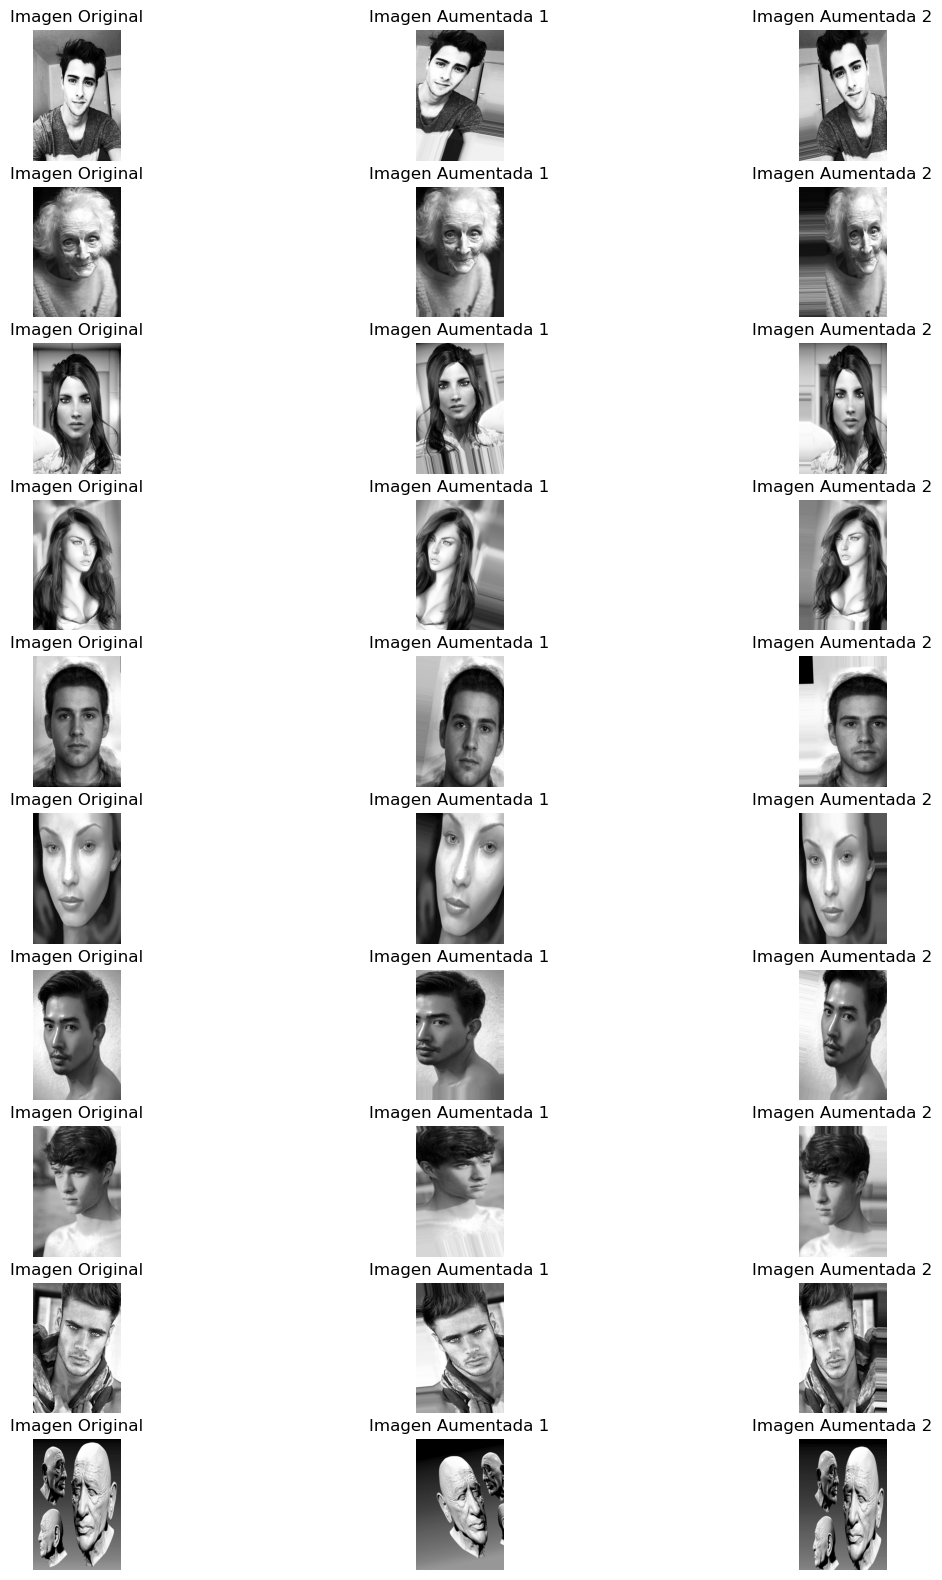

In [54]:
def plot_original_and_augmented_images(original_images, augmented_images, num_rows=10, num_cols=3, image_shape=(600, 400)):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 20))

    for i in range(num_rows):
        original_image = original_images[i]
        augmented_image_row = augmented_images[i * (num_cols - 1): (i + 1) * (num_cols - 1)]

        ax = axes[i, 0]
        ax.imshow(original_image.reshape(image_shape), cmap='gray')
        ax.set_title("Imagen Original")
        ax.axis('off')

        for j, image in enumerate(augmented_image_row):
            ax = axes[i, j + 1]
            ax.imshow(image.reshape(image_shape), cmap='gray')
            ax.set_title(f"Imagen Aumentada {j + 1}")
            ax.axis('off')

    plt.show()

# Llamar a la función para graficar
plot_original_and_augmented_images(original_images, augmented_images)

# Entrenar, optimizar y guardar modelo KNN
---

In [55]:
def entrenar_y_evaluar_modelo(X_train, y_train, X_test, y_test):
    # Crear un diccionario de parámetros para el grid search
    parametros_grid = {
        'n_neighbors': list(np.arange(2, 5, 1)),
        'metric': ['cosine', 'euclidean']
    }

    # Crear el modelo KNN
    modelo_knn = KNeighborsClassifier()

    # Realizar una búsqueda de hiperparámetros con diferentes métricas
    grid_search = GridSearchCV(modelo_knn, parametros_grid, cv=3)
    grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

    # Obtener los mejores parámetros
    mejores_parametros = grid_search.best_params_
    print("Mejores parámetros:", mejores_parametros)

    # Entrenar el modelo con los mejores parámetros
    modelo_knn_optimizado = KNeighborsClassifier(n_neighbors=mejores_parametros['n_neighbors'], metric=mejores_parametros['metric'])
    modelo_knn_optimizado.fit(X_train.reshape(X_train.shape[0], -1), y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = modelo_knn_optimizado.predict(X_test.reshape(X_test.shape[0], -1))

    # Evaluar el modelo optimizado
    exactitud = accuracy_score(y_test, y_pred)

    print("Exactitud del modelo optimizado:", exactitud)

    # Calcula la matriz de confusión
    confusion = confusion_matrix(y_test, y_pred)

    # Visualiza la matriz de confusión
    plt.figure(figsize=(8, 4))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.show()

    # Guardar el modelo optimizado en un archivo
    modelo_guardar = f'modelos/modelo_knn_optimizado_{str(np.round(exactitud,3)).replace(".","")}.pkl'
    with open(modelo_guardar, 'wb') as model_file:
        pickle.dump(modelo_knn_optimizado, model_file)

Mejores parámetros: {'metric': 'cosine', 'n_neighbors': 2}
Exactitud del modelo optimizado: 0.775


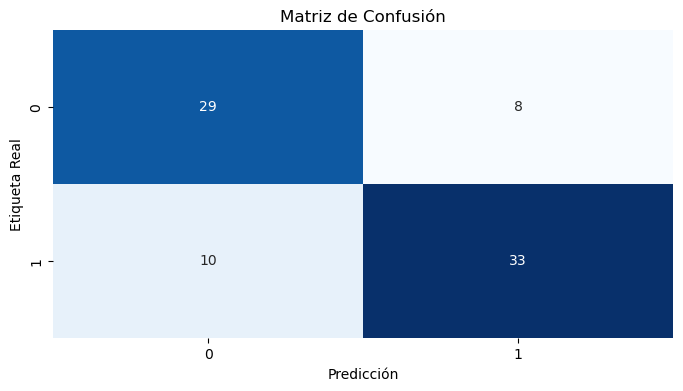

In [56]:
# Entrenar y evaluar el modelo
entrenar_y_evaluar_modelo(X_train, y_train, X_test, y_test)

Mejores parámetros: {'metric': 'euclidean', 'n_neighbors': 2}
Exactitud del modelo optimizado: 0.7625


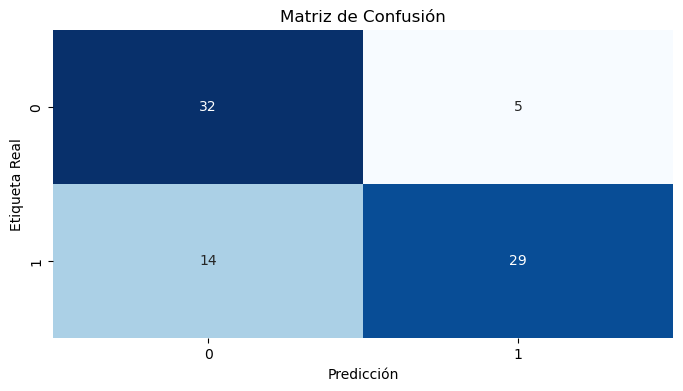

In [57]:
# Entrenar y evaluar el modelo
entrenar_y_evaluar_modelo(X_train_augmented, y_train_augmented, X_test, y_test)

# Importar y probar modelo
## **predecir_con_modelo**: Función para realizar pruebas con nuevas imagenes.
---

In [60]:
# Buscar nombre del modelo con el mejor score
modelos = os.listdir('modelos')
scores = [modelo.split("_")[-1].replace(".pkl","") for modelo in modelos]
idx = np.argmax(scores)
# idx = np.argmin(scores)
mejor_modelo = modelos[idx]
mejor_modelo

'modelo_knn_optimizado_0775.pkl'

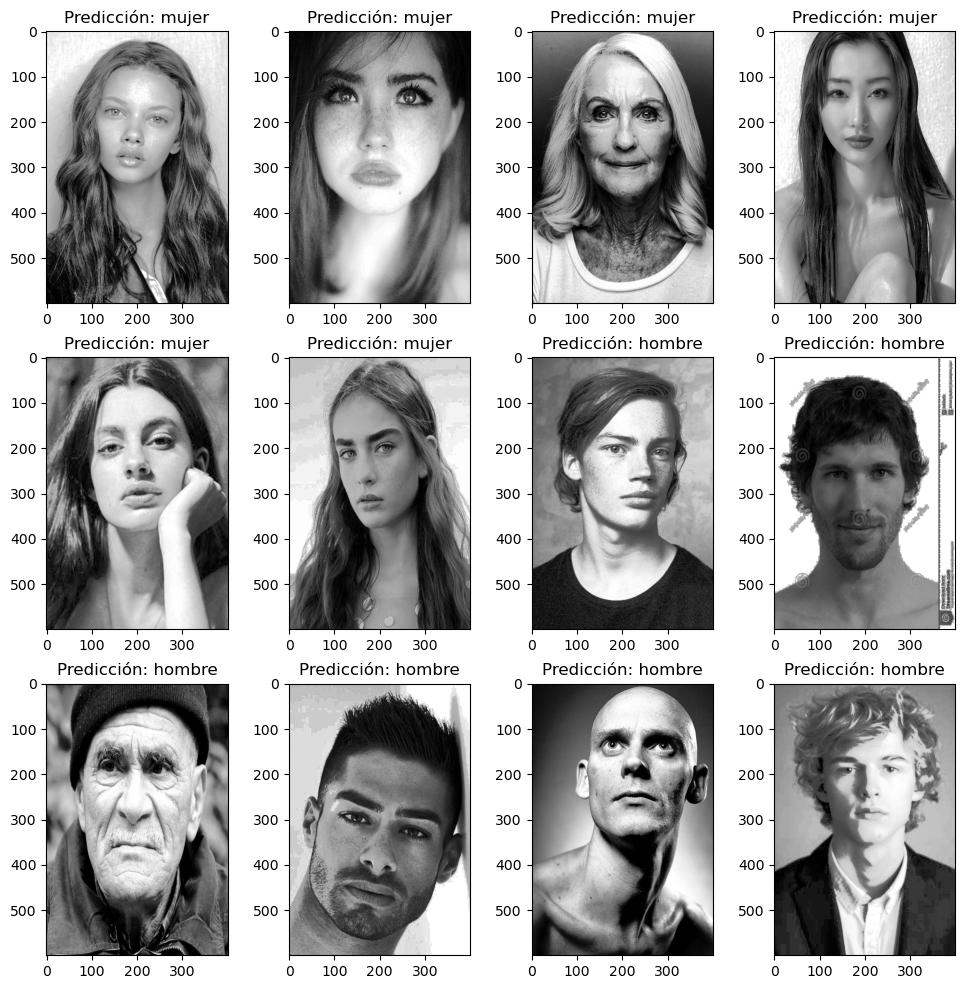

In [62]:
test_images_path = 'dataset/Pruebas'
model_path =  f'modelos/{mejor_modelo}'

# Función para cargar el modelo, aplicar transformaciones y predecir
def predecir_con_modelo(modelo_ruta, imagen_nueva):
    with open(modelo_ruta, 'rb') as model_file:
        knn_model = pickle.load(model_file)
    imagen = cv2.imread(imagen_nueva, cv2.IMREAD_GRAYSCALE)
    imagen = cv2.resize(imagen, (400, 600))
    imagen = exposure.equalize_hist(imagen)
    imagen_flatten = imagen.flatten()
    etiqueta_predicha = knn_model.predict([imagen_flatten])
    return imagen, etiqueta_predicha[0]

# Función para cargar imágenes desde el directorio test_images_path, predecir etiquetas y mostrar en un collage
def predecir_y_mostrar_resultados(modelo_ruta, test_images_path):
    num_cols = 4
    num_images = len(os.listdir(test_images_path))
    num_rows = math.ceil(num_images / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    axes = axes.ravel()

    for i, filename in enumerate(os.listdir(test_images_path)):
        if filename.endswith('.jpg') or filename.endswith(".jpeg") or filename.endswith('.png'):
            image_path = os.path.join(test_images_path, filename)
            imagen, etiqueta_predicha = predecir_con_modelo(modelo_ruta, image_path)
            etiqueta_texto = "hombre" if etiqueta_predicha == 1 else "mujer"
            axes[i].imshow(imagen, cmap='gray')
            axes[i].set_title(f'Predicción: {etiqueta_texto}')

    for i in range(len(os.listdir(test_images_path)), num_rows * num_cols):
        fig.delaxes(axes[i])

    plt.show()

# Llamar a la función para predecir y mostrar los resultados en forma de collage
predecir_y_mostrar_resultados(model_path, test_images_path)